In [1]:
using Pkg
Pkg.activate("schr_solv_env")

  Activating project at `~/Desktop/physics_coding_projects/julia/neutral_atom_solver/schr_solv_env`


In [2]:

using CSV
using Plots
using DataFrames

include("Grids.jl");
using .Grids;
include("Potentials.jl")
using .Potentials;
include("Hydrogen.jl")
using .Hydrogen;


include("Integral_Numerical_Methods.jl");
using .Integral_Numerical_Methods;

include("Math_Utils.jl")
using .Math_Utils


In [3]:
r_min::Float32=-10.0;
r_max::Float32=10.0;
N::Int32=100;
l::Int32=1;
Z::Int32=1;
w::Float32=1;
m::Float32=1;


In [4]:
unif_grid= Grids.uniform_grid(r_min, r_max, N);
expo_grid= Grids.exponential_grid(r_max, Z);

In [5]:
v_angu= Potentials.angular_potential(l, expo_grid);
v_colu= Potentials.coulomb_potential(Z, expo_grid);
v_harm= Potentials.harmoic_oscilator_potential(w, m, unif_grid);

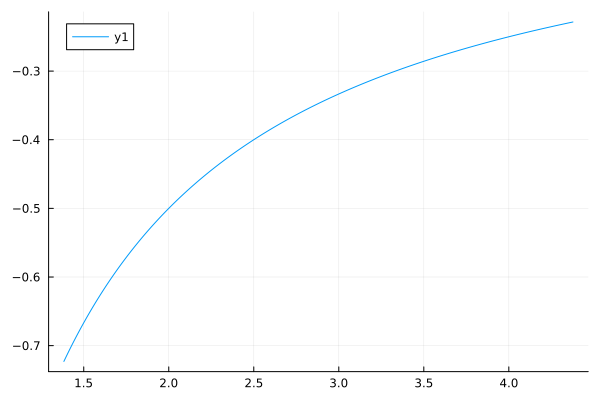

In [6]:
plot(expo_grid[5500:6000], v_colu[5500:6000])

In [7]:
u_s1_hydr= Hydrogen.u_s1_hydrogen(expo_grid);

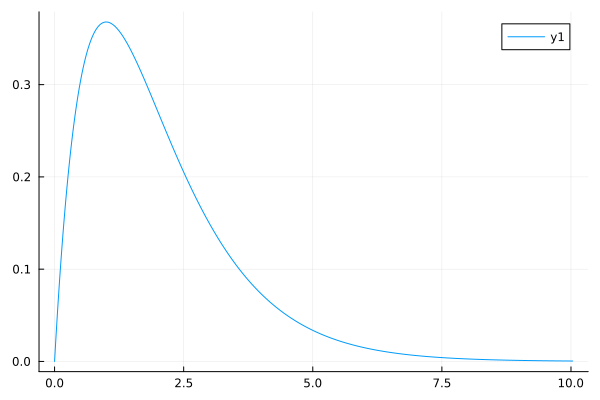

In [8]:
plot(expo_grid, u_s1_hydr)

In [9]:
E::Float32= -0.5000;
l::Int32=0;
v_effe= v_colu;
init_valu1::Float32=u_s1_hydr[1];#expo_grid[1]^(l+1.0)
init_valu2::Float32=u_s1_hydr[2];#expo_grid[2]^(l+1.0)
init_valu1_bwd::Float32=u_s1_hydr[end];#expo_grid[1]^(l+1.0)
init_valu2_bwd::Float32=u_s1_hydr[end-1];#expo_grid[2]^(l+1.0)
f::Vector{Float32}= 2.0.*(v_effe .- E);
#given f find the classical turning points
g=zeros(Float32, size(f)[1]);



In [10]:
#find turn_pnts of of f, basically the clasical turning points of the effective density_potential
#with restepect to the E proposed eigenvalue
turn_pnts= Math_Utils.turning_points_indices(f);
if length(turn_pnts) ==  0
    throw(DomainError("the effective potential has no turning points 
    for the proposed energy eigenvalue, this means v_effe - E has no zeroes"));
end


In [11]:
#do forward integration of radial shcrodinger equation u
u_fwd= Integral_Numerical_Methods.integrate_second_order_DE(expo_grid,g,f,init_valu1,init_valu2);
#do backward integreation of the radial shcrodinger equation u 
u_bwd= reverse(Integral_Numerical_Methods.integrate_second_order_DE(reverse(expo_grid),g,reverse(f),
                init_valu1_bwd,init_valu2_bwd));
#rescale u_fwd, u_bwd to make u_fwd[turn_pnts[1]] = u_bwd[turn_pnts[1]]
u_fwd, u_bwd= Math_Utils.rescale!(u_fwd, u_bwd, turn_pnts[1]);
#merge solutions
u_merged= Math_Utils.merge_solutions(u_fwd, u_bwd, turn_pnts[1]);



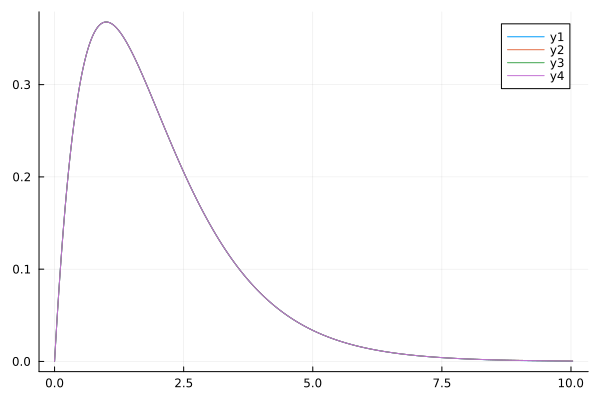

In [12]:
plot(expo_grid, [u_fwd, u_bwd, u_merged, u_s1_hydr])

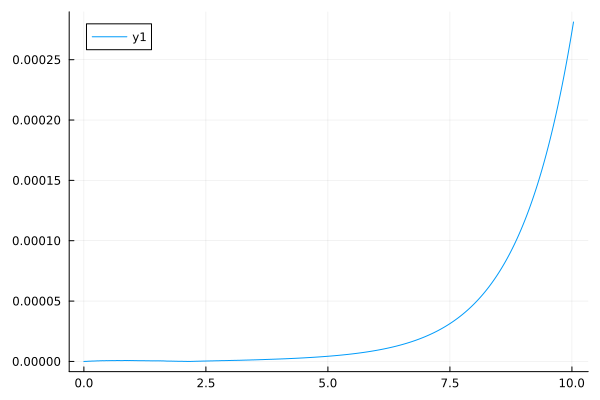

In [13]:
plot(expo_grid, ((u_fwd .- u_s1_hydr).^2).^0.5)

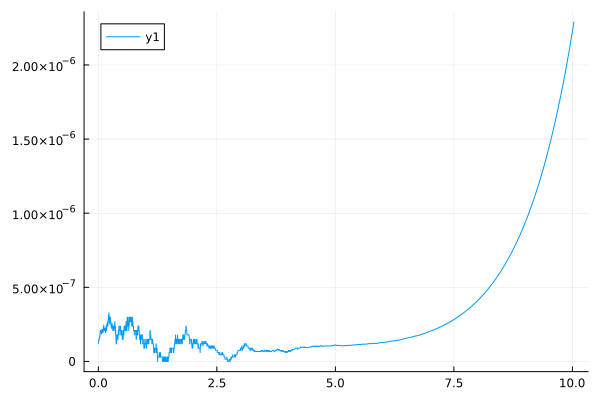

In [14]:
plot(expo_grid, ((u_bwd .- u_s1_hydr).^2).^0.5)

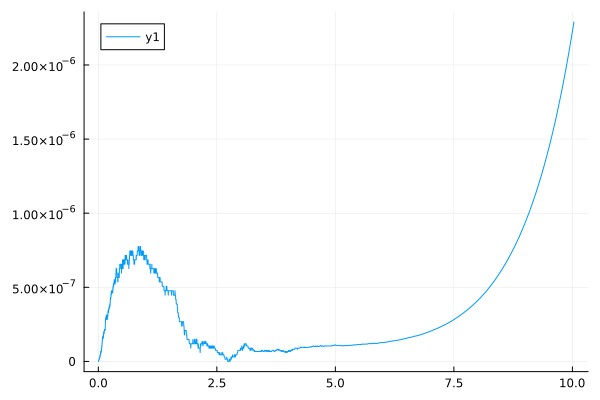

In [15]:
plot(expo_grid, ((u_merged .- u_s1_hydr).^2).^0.5)

In [31]:
#parameters needed to solve equation
E= -0.5000;
l=0;
v_effe= v_colu;
y_1=u_s1_hydr[1];#expo_grid[1]^(l+1.0)
y_2=u_s1_hydr[2];#expo_grid[2]^(l+1.0)
grid=expo_grid;
g0=zeros(Float32, 6)
g1=zeros(Float32, 6)
f0=ones(Float32, 6)
f1= 2.0.*(v_effe .- E);

N=size(v_effe)[1];

y0=zeros(Float32, N);#solution to differential equation
y1=zeros(Float32, N);#first derivative of solution to differential equation
y0[1]= y_1;
y1[1]= (y_2 - y_1)/(grid[2]-grid[1]);

for i in 1:4
#for i in 1:(N-1)
    h= grid[i+1] - grid[i];
    y0[i+1], y1[i+1]= Integral_Numerical_Methods.RK4(g1,f1[i:i+1],y0[i], y1[i],h);
end
#integration loop using prediction correction adams moulton degree 5
for i in 6:N
    h= grid[i] - grid[i-1];
    y0[i], y1[i]= Integral_Numerical_Methods.PCABM5(g1,f1[i-5:i],
                                            y0[i-5:i-1], y1[i-5:i-1],h);
end

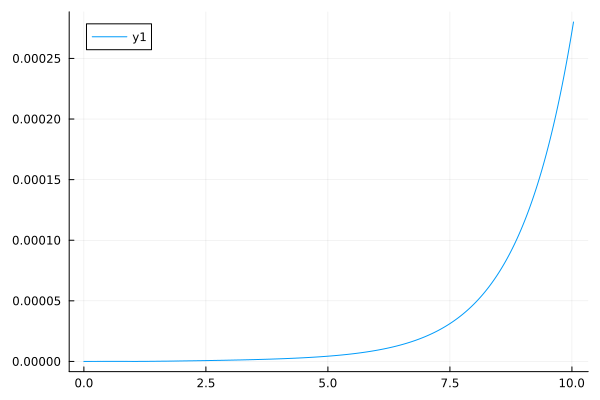

In [32]:
plot(expo_grid, ((y0 .- u_s1_hydr).^2).^0.5)

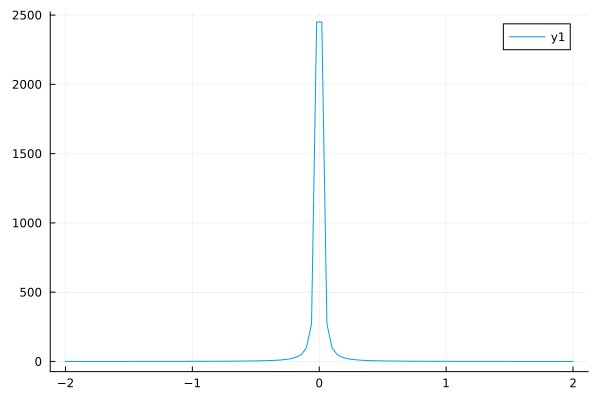

In [5]:
plot(unif_grid, v_angu)

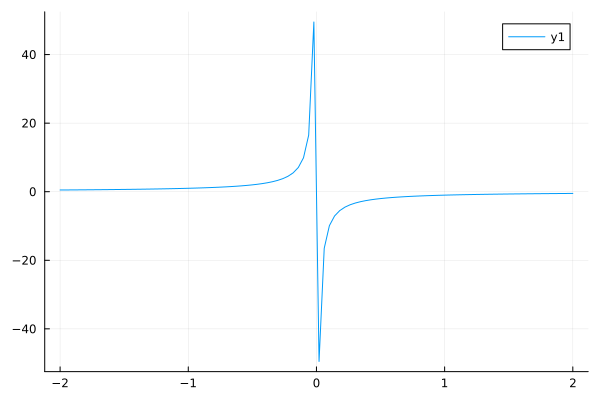

In [6]:
plot(unif_grid, v_colu)

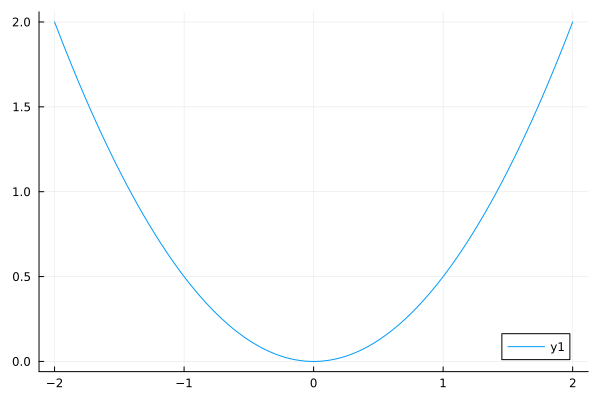

In [7]:
plot(unif_grid, v_harm)